## SPEI CALCULATION

SPEI index is one of the mostly used indices to assess drought conditions. We want to see how was the conditions for the D48 region, what the drought a contributing element in the forest change pattern?



In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pyproj
import gzip
import rasterio
import climate_indices
import spei
import fsspec
import netCDF4
import h5py
import zarr

Projection functions
The Evapotransipiration Dataset is in Gauss-Krüger 3rd meridian strip projection while the Precipitation is in EPSG:3034

In [25]:
def UTM_to_Gauss_Kruger(x,y):
    src_crs = pyproj.CRS("EPSG:4326")  # Google Earth projection
    target_crs = pyproj.CRS("EPSG:31467")  # Gauss-Krüger 3rd meridian strip

    # Define transformation method and parameters
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

    # Transform coordinates
    lon, lat = x, y  # Example longitude and latitude in decimal degrees
    x, y = transformer.transform(lon, lat)  # Transform to Gauss-Krüger 3rd meridian strip
    return x, y 

def UTM_to_EPSG3034(x,y):
    src_crs = pyproj.CRS("EPSG:4326")  # Google Earth projection
    target_crs = pyproj.CRS("EPSG:3034")  # EPSG:3034 

    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

    lon, lat = x, y  # Example longitude and latitude in decimal degrees
    x, y = transformer.transform(lon, lat)  # Transform to Gauss-Krüger 3rd meridian strip
    return x, y 


## Evapotranspiration

1. Below are functions to parse ASCI files to xarray.DataArray or xarray.DataSet objects.

In [26]:
# Function to get the time data from the file name.
def GetTimeFromFileName(fileDate):
    year_string = fileDate[0:4]
    year = int(year_string)
    month_string = fileDate[4:7]
    month = int(month_string)

    if (month == 1 or month==3 or month ==5 or month ==7 or month==8 or month==10 or month==12):
        return year_string +"-" + month_string +"-" + "31"
    elif (month == 4 or month==6 or month ==9 or month ==11):
        return year_string +"-" + month_string +"-" + "30"
    elif (year == 2020 and  month ==2):
        return year_string +"-" + month_string +"-" + "29"
    else:
        return year_string +"-" + month_string +"-" + "28"

def Parse_ASCIIFiles_To_DataSet(path , scale, unit):

    # Decompress the gzip file
    csv_files_decompressed = [gzip.open(os.path.join(file)) for file in os.scandir(path) if '.gz' in str(file)]
    
    # Initialize a list to add datasets to
    datasets = []

    for csv_file in csv_files_decompressed:
        
        # From the ET dataset documentation the upper-left cell (1st element in the ET array) has the following northing
        # and easting. We use them to construct the coordinates for the lon and lat we add resolution/2 to calculate the 
        # coordinate mid-pixel.
        northing_above = 6103501 - 1000/2
        easting_left = 3280414 + 1000/2
        
        # Get time entry
        filedate = csv_file.name.split("_")[6].split(".")[0]
        datestring = GetTimeFromFileName(filedate)

        # Read dataset
        dataset_reader = rasterio.open(csv_file, driver='AAIGrid')
        dataset = dataset_reader.read()

        # Set np.nan as nodata values and scale the data
        dataset =np.ma.masked_where(dataset == dataset_reader.nodata, dataset)
        dataset = dataset * scale

        # Construct xarray.Dataset object
        xr_dataset = xr.Dataset(
        data_vars = dict(
            et=(["time", "lat", "lon"], dataset),
        ), 
        coords=dict(
            time= np.array([datestring], dtype='datetime64'),
            lat = -np.arange(0,dataset_reader.height)*1000+northing_above,
            lon = np.arange(0,dataset_reader.width)*1000 + easting_left),
        attrs=dict(
            _FillValue= np.nan,
            units = unit
        ))

        # Add xr ds to list 
        datasets.append(xr_dataset)

    return xr.concat(datasets,'time').sortby("time")

def Parse_ASCIIFiles_To_DataArray(path, variable_name, scale, unit):

    # Decompress the gzip file
    csv_files_decompressed = [gzip.open(os.path.join(file)) for file in os.scandir(path) if '.gz' in str(file)]
    
    # Initialize a list to add datasets to
    dataarrays = []

    for csv_file in csv_files_decompressed:
        
        # From the ET dataset documentation the upper-left cell (1st element in the ET array) has the following northing
        # and easting. We use them to construct the coordinates for the lon and lat we add resolution/2 to calculate the 
        # coordinate mid-pixel.
        northing_above = 6103501 - 1000/2
        easting_left = 3280414 + 1000/2

        # Get time entry
        filedate = csv_file.name.split("_")[6].split(".")[0]
        datestring = GetTimeFromFileName(filedate)

        # Read dataset
        dataset_reader = rasterio.open(csv_file, driver='AAIGrid')
        dataset = dataset_reader.read()
        
        # Set np.nan as nodata values and scale the data
        dataset =np.ma.masked_where(dataset == dataset_reader.nodata, dataset)
        dataset = dataset * scale

        # Construct xarray.Dataarray object
        data_array = xr.DataArray(
        data=dataset,
        dims = ['time','lat', 'lon'],
        coords=dict(
            time= np.array([datestring], dtype='datetime64'),
            lat = -np.arange(0,dataset_reader.height)*1000+northing_above,
            lon = np.arange(0,dataset_reader.width)*1000 + easting_left),
        attrs=dict(
            resolution=dataset_reader.res,
            transform = dataset_reader.transform,
            _FillValue= np.nan,
            units = unit
        ),
        name = variable_name)
        dataarrays.append(data_array)

    return xr.concat(dataarrays,'time').sortby("time")
    

In [27]:
et_merged  = Parse_ASCIIFiles_To_DataSet(path = '/work/users/my982hzao/ET_RAW', scale = 0.1, unit="mm")
et_merged

<xarray.Dataset>
Dimensions:  (time: 74, lat: 866, lon: 654)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
  * lat      (lat) float64 6.103e+06 6.102e+06 6.101e+06 ... 5.239e+06 5.238e+06
  * lon      (lon) float64 3.281e+06 3.282e+06 3.283e+06 ... 3.933e+06 3.934e+06
Data variables:
    et       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:  nan
    units:       mm

2. Mask to Study Region

In [28]:

lon_min, lat_min, lon_max, lat_max = [10.294189,50.307024,11.961365,50.972242]
min_GK = UTM_to_Gauss_Kruger(lon_min, lat_min)
max_GK = UTM_to_Gauss_Kruger(lon_max, lat_max)
region_GK = (et_merged.lon >= min_GK[0]) & (et_merged.lat >= min_GK[1]) & (et_merged.lon <= max_GK[0]) & (et_merged.lat <= max_GK[1])

masked_ET = et_merged.where(region_GK).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
masked_ET

<xarray.Dataset>
Dimensions:  (time: 74, lat: 77, lon: 116)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
  * lat      (lat) float64 5.652e+06 5.651e+06 5.65e+06 ... 5.577e+06 5.576e+06
  * lon      (lon) float64 3.593e+06 3.594e+06 3.595e+06 ... 3.707e+06 3.708e+06
Data variables:
    et       (time, lat, lon) float64 6.0 5.9 5.9 6.2 ... 14.5 14.5 15.3 15.4
Attributes:
    _FillValue:  nan
    units:       mm

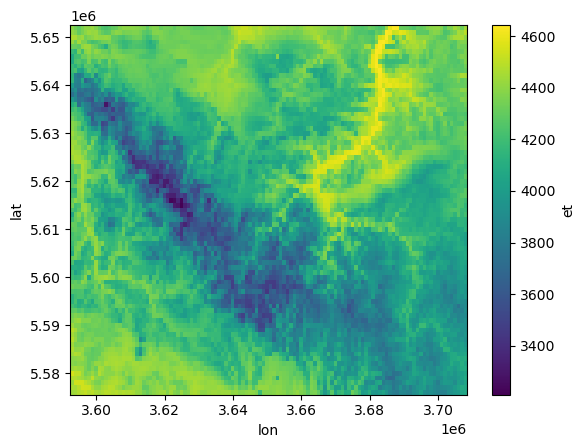

In [29]:
masked_ET.et.sum(dim='time').plot()

In [30]:
#masked_ET.to_zarr('/work/users/my982hzao'+'/evapotranspiration_UTM.zarr')

### 2. Preciptation

1. Fetch Precipitation dataset.

In [31]:
path = '/work/users/jn906hluu/Climate/Precipitation'
list_of_datasets = [xr.open_dataset(os.path.join(file)) for file in os.scandir(path) if '.nc' in str(file)]

pr_merged = xr.concat(list_of_datasets, dim='time')


/home/sc.uni-leipzig.de/my982hzao/.conda/envs/spei/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2. The Precipitation dateset has data that aren't present in the Evapotranspiration dataset, so we will make them more consistent. 

In [32]:
# (1) resample time to be monthly sum since the et dataset is for accumulated potential evapotranspiration monthly.
pr_resampled = pr_merged
pr_resampled = pr_resampled.sortby('time').resample(time='1M').sum()

# (2) drop unneeded stuff
pr_resampled =pr_resampled.drop_vars(["x_bnds","y_bnds","crs_HYRAS","number_of_stations"])
pr_resampled = pr_resampled.drop([i for i in pr_resampled.coords if i not in pr_resampled.dims])
del pr_resampled.pr.attrs['grid_mapping']
pr_resampled.attrs['units'] = 'mm'
pr_resampled.attrs['_FillValue'] = np.nan

# (3) drop extra time entry which isn't in et dataset
pr_resampled =pr_resampled.drop(labels='2023-03-31',dim="time" )

pr_resampled

/tmp/ipykernel_2058768/877980866.py:13: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  pr_resampled =pr_resampled.drop(labels='2023-03-31',dim="time" )


<xarray.Dataset>
Dimensions:  (time: 74, y: 1100, x: 1200)
Coordinates:
  * x        (x) float32 3.5e+06 3.502e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y        (y) float32 2.1e+06 2.102e+06 2.102e+06 ... 3.198e+06 3.2e+06
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
Data variables:
    pr       (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/22)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc
    units:                     mm
    _FillValue:                nan

3. Mask to Study Region

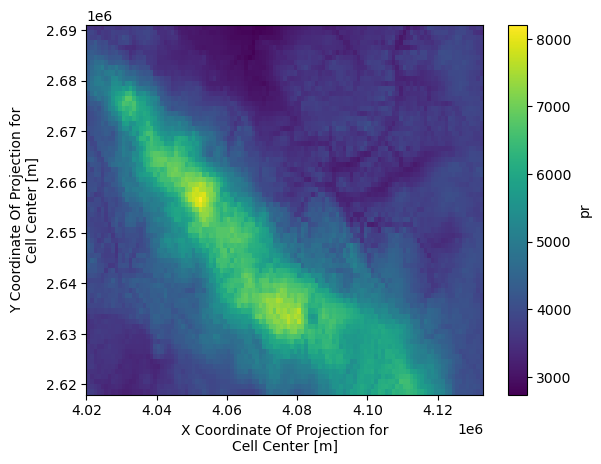

In [33]:
min_EPSG3034 = UTM_to_EPSG3034(lon_min, lat_min)
max_EPSG3034 = UTM_to_EPSG3034(lon_max, lat_max)
region_EPSG3034 = (pr_resampled.x >= min_EPSG3034[0]) & (pr_resampled.y >= min_EPSG3034[1]) & (pr_resampled.x <= max_EPSG3034[0]) & (pr_resampled.y <= max_EPSG3034[1])

masked_PR = pr_resampled.where(region_EPSG3034).dropna(dim='x', how='all').dropna(dim='y', how='all')
masked_PR.pr.sum(dim='time').plot()

In [34]:
masked_PR

<xarray.Dataset>
Dimensions:  (time: 74, y: 73, x: 113)
Coordinates:
  * x        (x) float32 4.02e+06 4.022e+06 4.022e+06 ... 4.132e+06 4.132e+06
  * y        (y) float32 2.618e+06 2.62e+06 2.62e+06 ... 2.69e+06 2.69e+06
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
Data variables:
    pr       (time, y, x) float32 26.0 25.2 23.3 21.9 ... 44.5 43.7 45.4 43.3
Attributes: (12/22)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc
    units:                     mm
    _FillValue:                nan

The final inconsistency is the that each dataset has a different projection, we will reproject the et dataset to pr dataset

In [35]:
# renaming dims to match pr dataset naming and the reprojection works
masked_ET = masked_ET.rename({"lon": "x", "lat": "y"})

# assigning each set's projection to it's xarray.dataset object
masked_PR.rio.write_crs("EPSG:3034", inplace=True)
masked_ET.rio.write_crs("EPSG:31467", inplace=True)

et_reprojected = masked_ET.rio.reproject_match(masked_PR)
et_reprojected

<xarray.Dataset>
Dimensions:      (x: 113, y: 73, time: 74)
Coordinates:
  * x            (x) float32 4.02e+06 4.022e+06 ... 4.132e+06 4.132e+06
  * y            (y) float32 2.618e+06 2.62e+06 2.62e+06 ... 2.69e+06 2.69e+06
  * time         (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
    spatial_ref  int64 0
Data variables:
    et           (time, y, x) float64 5.4 5.4 5.4 5.5 ... 18.7 17.6 17.8 18.8
Attributes:
    _FillValue:  nan
    units:       mm

In [36]:
#Final et
print("ET Final")
et_reprojected = et_reprojected[["y","x","time","et"]]
et_reprojected = et_reprojected.rename({"x": "lon", "y": "lat"})
print(et_reprojected.rio.crs)
print(et_reprojected.dims)
et_final = et_reprojected

#Final pr
print("PR Final")
masked_PR = masked_PR[["y","x","time","pr"]]
masked_PR = masked_PR.rename({"x": "lon", "y": "lat"})
print(masked_PR.rio.crs)
print(masked_PR.dims)
pr_final=masked_PR

ET Final
EPSG:3034
Frozen({'lat': 73, 'lon': 113, 'time': 74})
PR Final
EPSG:3034
Frozen({'lat': 73, 'lon': 113, 'time': 74})


/home/sc.uni-leipzig.de/my982hzao/.conda/envs/spei/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


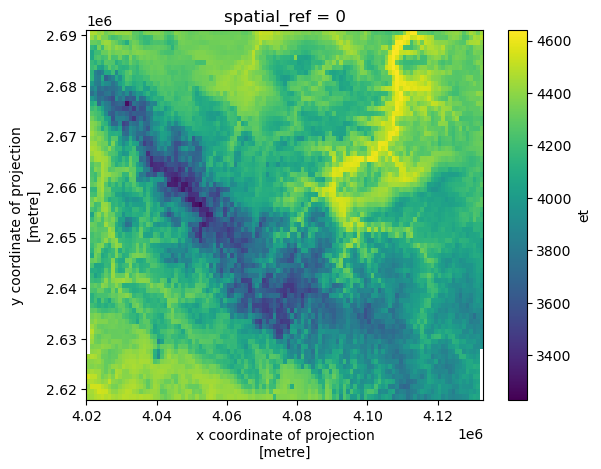

In [43]:
et_final.et.sum(dim='time').plot()

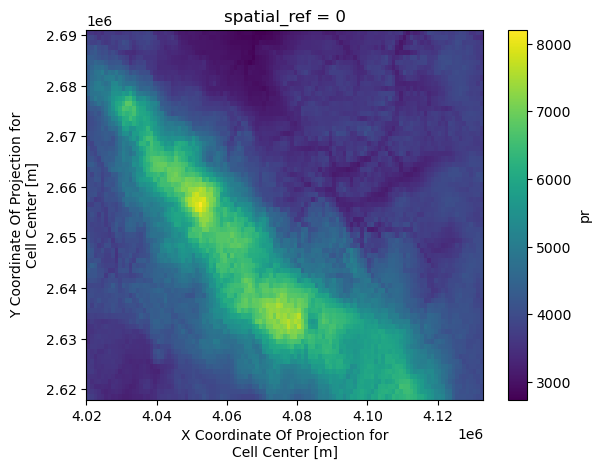

In [44]:

pr_final.pr.sum(dim='time').plot()

In [45]:
# Write to netCDF file
path = "/work/users/my982hzao/SPEI"

et_final.to_netcdf(path+"/et_rec.nc")
pr_final.to_netcdf(path+"/pr_rec.nc")

In [ ]:
path = '/work/users/my982hzao/'
ds_CF = xr.open_zarr(fsspec.get_mapper(path + 'S2_Frankenwald_CF_20.zarr'),
                  consolidated=True)

ds_CF

<xarray.Dataset>
Dimensions:        (time: 68, band: 12, lat: 7530, lon: 11540)
Coordinates:
  * band           (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat            (lat) float64 50.97 50.97 50.97 50.97 ... 50.31 50.31 50.31
  * lon            (lon) float64 10.29 10.29 10.29 10.29 ... 11.96 11.96 11.96
  * time           (time) datetime64[ns] 2017-01-22 2017-03-26 ... 2022-12-11
Data variables:
    CF             (time) float64 dask.array<chunksize=(68,), meta=np.ndarray>
    forest_mask    (lat, lon) float64 dask.array<chunksize=(942, 1443), meta=np.ndarray>
    forest_region  (lat, lon) int64 dask.array<chunksize=(942, 1443), meta=np.ndarray>
    mask           (time, lat, lon) int8 dask.array<chunksize=(1, 942, 1443), meta=np.ndarray>
    refl           (time, band, lat, lon) float64 dask.array<chunksize=(1, 1, 471, 1443), meta=np.ndarray>
Attributes: (12/14)
    author:                       Joshua Müller
    band_dimension:               bands
    band_scale_factor:            10000
    band_units:                   DN
    coordinate_reference_system:  EPSG:4326
    creation_date:                2023-02-13
    ...                           ...
    platform:                     Sentinel-2
    product_type:                 Level-2A
    projection:                   plane
    resolution:                   10m
    wavelength_units:             nanometers
    wavelengths:                  [443, 490, 560, 665, 705, 740, 783, 832, 94...

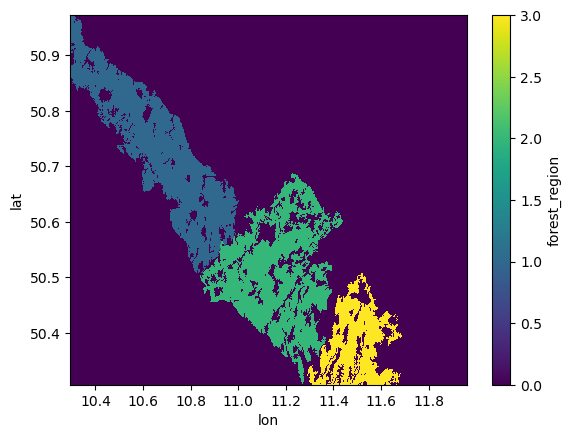

In [ ]:
ds_CF["forest_region"].plot()

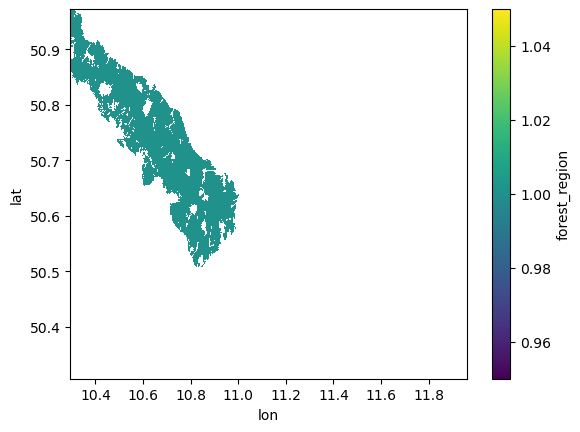

In [ ]:
ds_CF_20.forest_region.where(ds_CF_20["forest_region"] == 1).plot()


In [ ]:
# import zarr
path = '/work/users/my982hzao/'

# Open the Zarr array
# z = zarr.open(path + 'soil_moisture_masked.zarr/')
# z.store.create_metadata()

ds_CF_20 = xr.open_zarr(fsspec.get_mapper(path + 'Climate_variables/soil_moisture_masked.zarr/'),
                  consolidated=True)

ds_CF_20_ff = xr.open_zarr(fsspec.get_mapper(path + 'soil_moisture_monthly_UTM.zarr/'),
                  consolidated=True)

ds_CF_20_ff

<xarray.Dataset>
Dimensions:  (lat: 77, lon: 116, time: 98)
Coordinates:
  * lat      (lat) float64 51.0 50.99 50.98 50.97 ... 50.34 50.33 50.32 50.31
  * lon      (lon) float64 10.3 10.32 10.33 10.35 ... 11.92 11.93 11.94 11.96
  * time     (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2023-02-28
Data variables:
    sm       (time, lat, lon) float64 dask.array<chunksize=(25, 39, 58), meta=np.ndarray>

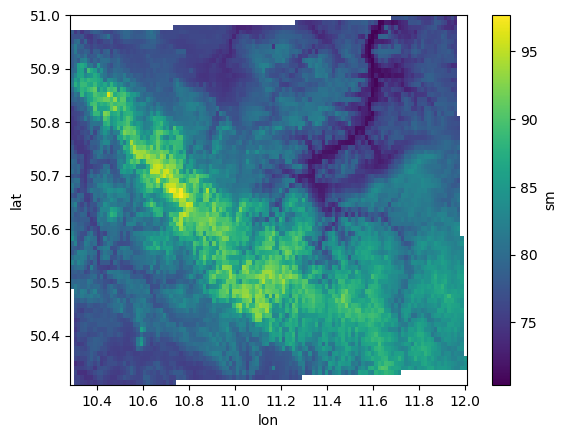

In [ ]:
ds_CF_20.sm.mean(dim='time').plot()


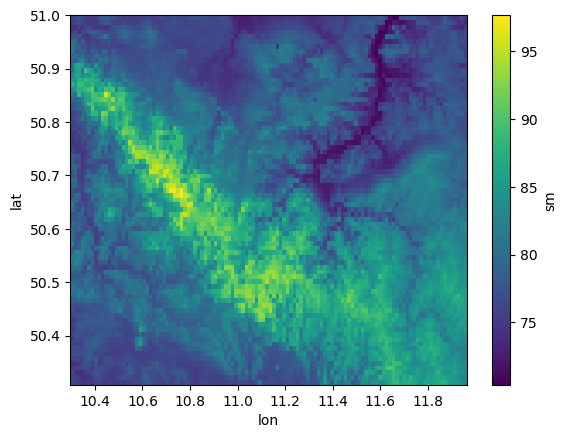

In [ ]:
ds_CF_20_ff.sm.mean(dim='time').plot()

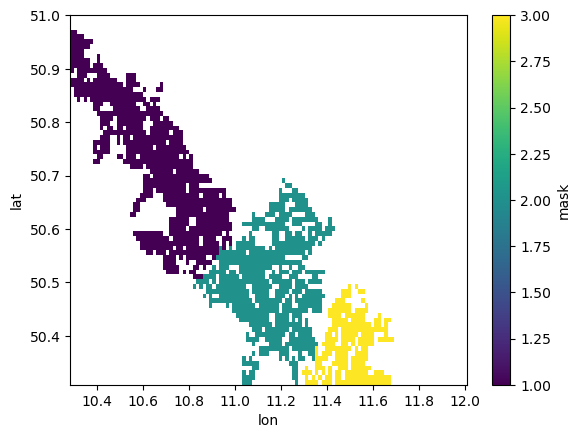

In [ ]:
ds_CF_20.mask.plot()


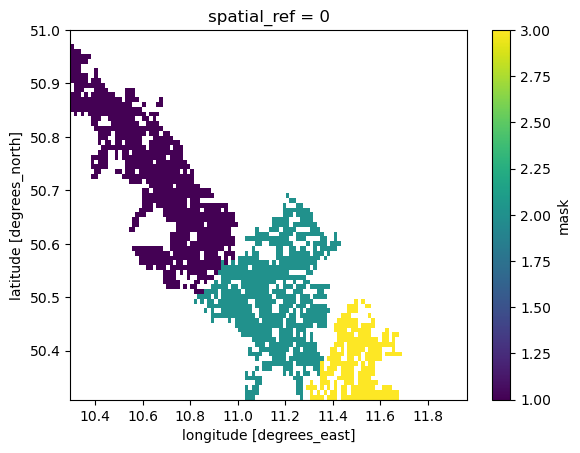

In [ ]:
# ds_CF_20_ff.sm.mean(dim='time').where(ds_CF_20["mask"] == 1, other=np.nan).plot()

mask = ds_CF_20["mask"]
mask = mask.rename({"lon": "x", "lat": "y"})
mask
sm_utm = ds_CF_20_ff.sm
sm_utm=sm_utm.rename({"lon": "x", "lat": "y"})
# assigning each set's projection to it's xarray.dataset object
mask.rio.write_crs("EPSG:4326", inplace=True)
sm_utm.rio.write_crs("EPSG:4326", inplace=True)

mask_2 = mask.rio.reproject_match(sm_utm)
mask_2.plot()

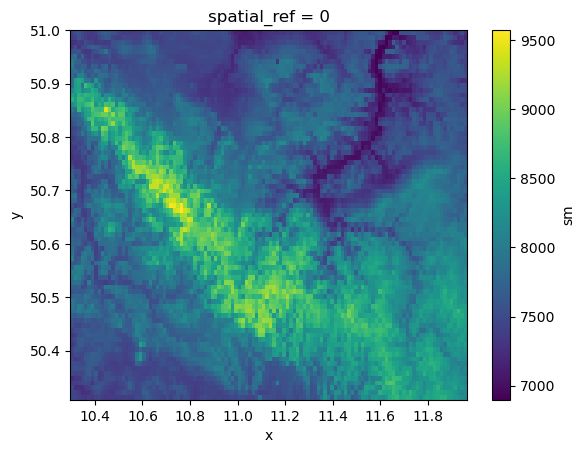

In [ ]:
sm_utm.sum(dim='time').plot()

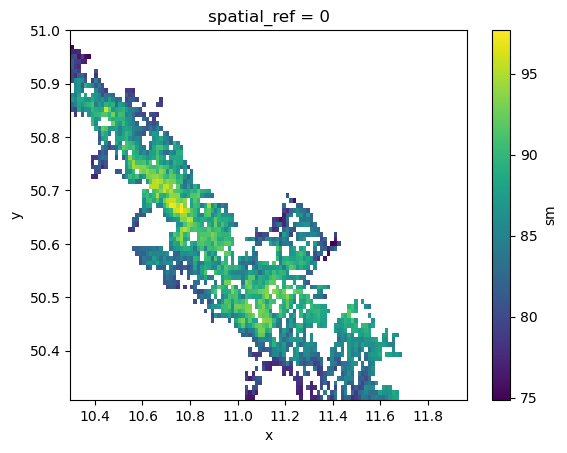

In [ ]:
sm_utm.mean(dim='time').where(mask_2<4, other=np.nan).plot()
